In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
from qick import *
from pickle_parser import *
import Pyro4
%pylab inline

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "192.168.2.99"
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib

QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ


In [3]:
from phase_calibration import *

In [4]:
res = []
freqs = np.arange(1, 501, 1)
config = {"reps": 1}
# freqs=[60]
for freq in freqs:
    config['pulse_freq'] = freq
    prog = CalibratePhase(soccfg, config)
    data = prog.acquire_decimated(soc, progress=False)
    res.append([prog.calculate_phase(d) for d in data])
    soc.reset_gens()

sync = {}
for i in range(len(freqs)):
    print(freqs[i], (res[i][0][0] - res[i][1][0])%360)
    sync[freqs[i]] = (res[i][0][0] - res[i][1][0]) % 360

# print(prog)
# print(data)
# print(sync)

1 2.637057922443603
2 4.412398390686349
3 4.6117791567832285
4 4.533102593284696
5 4.164430192221289
6 4.066719106577239
7 3.863328192395784
8 3.987918320523022
9 4.243843361850736
10 4.356244233689608
11 4.546112082194043
12 4.824314335879762
13 5.018970597872396
14 5.274220127577166
15 5.552139170420048
16 5.822978165170412
17 6.0136329162016295
18 6.336837169948581
19 6.668468720849262
20 6.89764187857071
21 7.21908292691478
22 7.456702687632969
23 7.882263279973415
24 8.20218611937679
25 8.540404254624434
26 8.957605955191752
27 9.353174600189618
28 9.79948409627724
29 10.269718609131075
30 10.822321032676825
31 11.374314748838458
32 11.910468525490728
33 12.509068221058499
34 13.243415833893891
35 14.05456765582278
36 14.720523223479802
37 15.569674787134545
38 16.54663570057403
39 17.385152707406007
40 18.35222060126563
41 19.500999027478088
42 20.592888485912056
43 21.83403274731711
44 23.001223908249017
45 24.296620545900026
46 25.7812524998821
47 27.092109048367547
48 28.45159

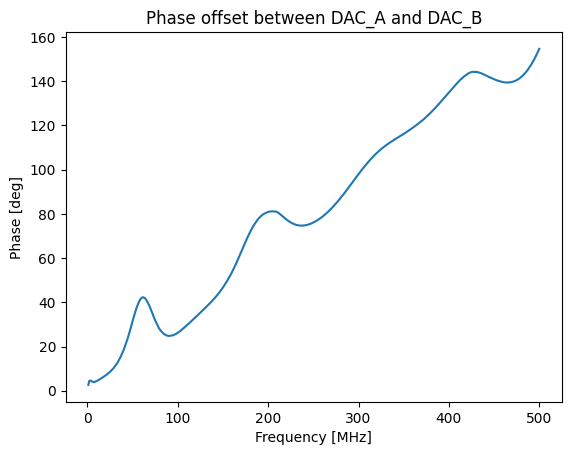

In [410]:
x = list(sync.keys())
y = list(sync.values())
coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef)
# plt.plot(x, poly1d_fn(x), '--')
plt.plot(x,y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase [deg]")
plt.title("Phase offset between DAC_A and DAC_B");

In [409]:
freq = 300

# phi = sync[freq]-360*freq*35e-5
phi = poly1d_fn(freq) - 360*freq*35e-5
phases = [phi, 0]
print(freq,phi)

prog = QickProgram(soccfg) # Create program object
gains = [30000,30000]
for ch in range(2):
    prog.declare_gen(ch=ch, nqz=1)
    prog.trigger(pins=[0]) # send a pulse on pmod0_0, for scope trigger
    prog.set_pulse_registers(ch=ch, gain=gains[ch], freq=prog.freq2reg(freq), phase=prog.deg2reg(phases[ch], gen_ch=ch), style="const", length= prog.us2cycles(10, gen_ch=ch))
    prog.pulse(ch=ch, t=0)
prog.wait_all()
prog.end()

prog.config_all(soc) # Load assembly to board
soc.tproc.start() # Run program
# print(prog)

300 60.086275246245094
